# Quantum Computation - Week 7

&nbsp;

## Contents

&nbsp;

1. [Quantum Period Finding](#qpf)
2. [Quantum Phase Estimation](#phase)

&nbsp;

**Module Imports**

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# importing Qiskit
from qiskit import Aer, IBMQ
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, transpile

from qiskit.tools.visualization import plot_histogram

#IBMQ.load_account()

import math
from math import pi

In [6]:
# Plot results
def show_results(D):
    # D is a dictionary with classical bits as keys and count as value
    # example: D = {'000': 497, '001': 527}
    plt.bar(range(len(D)), list(D.values()), align='center')
    plt.xticks(range(len(D)), list(D.keys()))
    plt.show()

# Execute circuit, display a histogram of the results
def execute_locally(qc, draw_circuit=False):
    # Compile and run the Quantum circuit on a simulator backend
    backend_sim = Aer.get_backend('qasm_simulator')
    job_sim = execute(qc, backend_sim)
    result_sim = job_sim.result()
    result_counts = result_sim.get_counts(qc)
    
    # Print the results
    print("simulation: \n\n", result_counts)
    show_results(result_counts)
    return result_counts


&nbsp;

## 1. Quantum period finding <a id='qpf'></a>

&nbsp;

Admit a function $f(x)$ from $n$-bit numbers to $m$-bit numbers. Consider $f(x)$ periodic of period $r$, meaning that $\forall x \in \{0,\cdots,N-r-1\}$, we have that $f(x) = f(x+r)$ and the values $f(x), f(x+1), \cdots, f(x+r-1)$ are all distinct. Suppose also that $ r \leq \sqrt{N}/2$


In a quantum algorithm, this function translates to an $n$-qubit input register and an $m$-qubit output register. We can prepare in the state:

$$ | \psi_0 \rangle = \frac{1}{\sqrt{N}} \sum_{x=0}^{2^n-1} | x\rangle |0\rangle$$

Using $n$ Hadamard gates.

We then apply a circuit that performs the unitary $\hat{U}_f$:

$$\hat{U}_f | \psi_0 \rangle =\frac{1}{\sqrt{N}} \sum_{x=0}^{2^n-1} | x\rangle | f(x) \rangle$$

If we measure the output register _only_ , we get a particular value $a$. The input register will be left in an evenly-weighted superposition of all $x$ such that $f(x) = a$:

$$\frac{1}{\sqrt{N/r}} \sum_{n=0}^{N/r-1} |x_0 + nr \rangle | a \rangle$$

From now on, we will ignore the output register since the measurement has fixed its state.

If we apply the QFT to the input register, we will gate a state in the form:

$$\sum_{m=0}^{r-1} \alpha_m |m N/r\rangle$$

If we now measure the input register, we would get one value $mN/r$, for some random $m$ between $0$ and $r-1$.

* This is not enough to tell us the value of $N/r$, but if we run the algorithm $d$ times, we will get a sequence of integers $m_1 N/r, \cdots, m_d N/r$ which are all multiples of $N/r$.


<div class="alert alert-block alert-warning">

**Exercise 1**

&nbsp;

Using the period finding technique detailed above, find the period of the function $f:\{0,1\}^3 \rightarrow \{0,1\}^3$ below.

&nbsp;

Notes:

* For a sufficiently large number of runs $d$ (which grows moderately in $N$) we can be confident that, with high probability, $N/r$ is the only common factor of all the numbers.


</div>

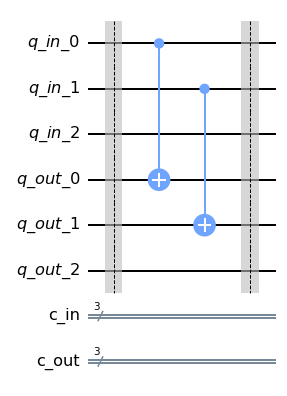

In [6]:
qin = QuantumRegister(3, 'q_in')
qout = QuantumRegister(3, 'q_out')
cin = ClassicalRegister(3, 'c_in')
cout = ClassicalRegister(3, 'c_out')
qc = QuantumCircuit(qin, qout, cin, cout)

qc.barrier()

#Uf
qc.cx(qin[0],qout[0])
qc.cx(qin[1],qout[1])

qc.barrier()

qc.draw(output='mpl')

In [ ]:
from math import gcd
from functools import reduce

#Simulate
simulator = Aer.get_backend('qasm_simulator')
job = execute(qc, simulator, shots=10)
result = job.result()
counts = result.get_counts(qc)

# convert to numbers
k=[]
for i in counts.keys():
    k.append(int(i[4:7],2))

# get the maximum common divisor
x = reduce(gcd, k)

# period:
n=qin.__len__()
r=int(2**n/x)
print("the period is: "+str(r)+".")

## 2. Phase estimation<a id='phase'></a>

&nbsp;

The phase estimation algorithm is a solution to a rather specific problem. However, similarly to the QFT and Grover's search algorithm, it turns out to be useful as a building block to several other algorithms to solve more general and important problems.

Suppose we have a unitary operator $\hat{U}$ operating on $n$-qubits, with a known eigenstate$^1$ $| \psi \rangle$ and an associated unknown eigenvalue $e^{i \theta{\psi}}$. We want to find the eigenvalue / phase, which means finding phase $\theta{\psi}$ with $m$-bits of precision.


 $$U |u \rangle = e^{i \theta_{\psi}}|u \rangle$$


We might try to prepare $n$ qubits in the state $|\theta{\psi} \rangle$ and carry out the unitary transformation $\hat{U}$ on them:


<img src="https://i.stack.imgur.com/9AFj7.png" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="100 px" align="center"> 


$^1$: An eigenstate is a quantum mechanical state whose wave function is an eigenvector that corresponds to a physical quantity.

<div class="alert alert-block alert-info">
    
**Question**: is there a measurement on the bits which will give us information about the phase $\phi$?

The answer is **no**: $\hat{U}$ just produces an overall phase on the state, with no observable consequences.

</div>

&nbsp;

Before we look into a more sophisticated approach to the problem, it's important to understand **phase kickback**.

### Phase kickback

&nbsp;

A key part of understanding the phase kickback is that $|\psi\rangle$ is an eigenvector of the operator $U$ with an eigenvalue of $e^{2\pi i \phi}$. In other words, $U|\psi\rangle = e^{2\pi i \phi}|\psi\rangle$, where $\phi$ is the phase that we are interested in 'kicking back'. A small example:

<img src="https://miro.medium.com/max/3600/1*DudEik8tsL5rl1aq-DUh-A.jpeg" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="center"> 

&nbsp;

The system's state starts simply $|0\rangle|\psi\rangle$. 

&nbsp;

**After the first Hadamard**, the Hadamard operator has converted $|0\rangle$ into $H|0\rangle = |+\rangle = \frac{|0\rangle+|1\rangle}{\sqrt{2}} $. Thus, at point B, the whole system is in the state

$$\frac{|0\rangle+|1\rangle}{\sqrt{2}}|\psi\rangle = \frac{|0\rangle|\psi\rangle+|1\rangle|\psi\rangle}{\sqrt{2}}$$

&nbsp;

**After th CU** , the system is in the state 

&nbsp;

$$\frac{|0\rangle|\psi\rangle+|1\rangle U|\psi\rangle}{\sqrt{2}} = \frac{|0\rangle+e^{i \theta_{\psi}}|1\rangle}{\sqrt{2}}|\psi\rangle$$

&nbsp;

Note how the state $|\psi\rangle$ remains unchanged. This happens because applying $\hat{U}$ to $|\psi \rangle$ results in a "multiple" $e^{ i \theta{\psi}}$ of $|\psi \rangle$, which can be factored out. **This is only possible since we admit that $|\psi\rangle$ is an eigenstate of $\hat{U}$**.

&nbsp;

Now, let's consider higher powers of $U$, e.g. $U^2$. 

In this case, $|\psi\rangle$ is still an eigenvector of $U^2$.

More generally, $U^x |\psi\rangle = e^{x i \theta{\psi}}|\psi\rangle$ . 

In other words, **an eigenvector of $U$ is also an eigenvector of $U^x$; just with an eigenvalue that is raised to the power $x$**.

Thus, for a general $U^{2^k}$, after the CU, the system would be in the state

$$\frac{|0\rangle|\psi\rangle+|1\rangle U^{2^k}|\psi\rangle}{\sqrt{2}} = \frac{|0\rangle+e^{i 2^k \theta{\psi}}|1\rangle}{\sqrt{2}}|\psi\rangle$$

### Phase estimation algorithm

&nbsp;

The first part of the phase estimation algorithm consists in a paralell application of the phase kickback technique detailed above, to successive powers of $U$:

&nbsp;

<img src="https://qiskit.org/textbook/ch-algorithms/images/qpe_tex_qz.png" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="600 px" align="center"> 

&nbsp;

The complete phase estimation procedure is as follows:

1. Prepare the $t$-bit control register in state $|0 \rangle$, and the target register in state $|u\rangle$ (eigenstate of $U$);

2. Perform Hadamards on the control bits.

3. Apply a controlled-$\hat{U}^{2^j}$, from the $j$th control bit onto the n target bits for each of the control q-bits in succession.

4. Perform an **inverse** Fourier transform on the $t$ control bits and measure them in the computational basis. The measured bit values $\phi_1, \cdots, \phi_n$ give an estimate of the phase $\phi \approx 0.\phi_1 \cdots \phi_n$, or $\phi \approx \frac{\phi_1}{2}+ \cdots + \frac{\phi_n}{2^n}$.

<div class="alert alert-block alert-warning">

**Exercise 1 - Estimate the Phase of T of $$**

&nbsp;

1. Implement the phase estimation algorithm to estimate, **to 3 bits of precision**, the the phase of $T |1\rangle = e^{\frac{i \pi}{4}}|1\rangle$

Since we are looking for $\theta$ in $T |1\rangle = e^{2 i \pi \theta} |1\rangle$ we expect to find $\theta = \frac{1}{8}$

3. What is the result for eigenstate $|0 \rangle$?

&nbsp;

</div>

In [7]:
def qft_dagger(qc, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-math.pi/float(2**(j-m)), m, j)
        qc.h(j)

In [ ]:
n=3
qctrl = QuantumRegister(n)
qtrg= QuantumRegister(1)
cr = ClassicalRegister(n)






qc.draw(output='mpl')

simulation: 

 {'001': 1024}


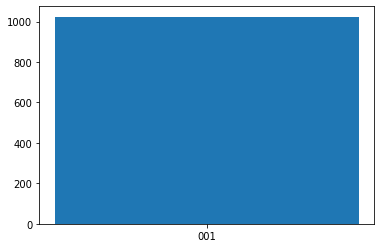

In [17]:
a = execute_locally(qc)

In [18]:
def binaryToDecimal(binary):
    binary1 = binary
    decimal, i, n = 0, 0, 0
    while(binary != 0):
        dec = binary % 10
        decimal = decimal + dec * pow(2, i)
        binary = binary//10
        i += 1
    return(decimal)    

In [20]:
key = list(a.keys())[0]
r = binaryToDecimal(int(key))
theta= r/(2**n)

print(theta)

0.125


<div class="alert alert-block alert-warning">

**Exercise 2 - Implementing the phase estimation algorithm**

&nbsp;

Implement a function `phase_est(qc, qr_ctrl, qr_trg, theta, phi, lambda, n)` to create a phase estimation circuit in `qc` with `n` bits of precision, for a general single-qubit operation

&nbsp;

$$
u_3(\theta, \phi, \lambda) = 
	    \begin{pmatrix}
        \cos{(\theta/2)} & -e^{i\lambda}\sin{(\theta/2)}\\ 
        e^{i\phi}\sin{(\theta/2)} & e^{i(\lambda + \phi)}\cos{(\theta/2)}
        \end{pmatrix}
$$

&nbsp;

**Note**: The algorithm can be tested by defining an eigenstate `psi` of $u_3$ as a vector of complex coefficients. The state can be created using `qc.initialize(psi, qubit)`.

&nbsp;

</div>

In [26]:
#qc.cu(theta, phi, lambda, 0, ctrl, trg)
def phase_est(qc, qr_ctrl, qr_trg, theta, phi, lamda):


In [ ]:
n=3
q_ctrl=QuantumRegister(n)
q_trg=QuantumRegister(1)
cr=ClassicalRegister(n)
qc=QuantumCircuit(q_ctrl, q_trg, cr)

phase_est(qc, q_ctrl, q_trg, pi/2, pi/2, pi/2)

qc.measure(q_ctrl, cr)
qc.draw(output='mpl')